# Inspect Forcing Data

In [147]:
import xarray as xr
from datetime import datetime
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas
from glob import glob
import numpy as np
import wrfhydro_utils
#import cartopy.crs as ccrs

%matplotlib inline

In [148]:
#import multiprocessing.popen_spawn_posix
from dask.distributed import Client

# instantiate the Dask dashboard interface
Client()  

/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54426 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:54426/status,
Dashboard: http://127.0.0.1:54426/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54427,Workers: 4
Dashboard: http://127.0.0.1:54426/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:54441,Total threads: 3
Dashboard: http://127.0.0.1:54443/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:54430,


## Load NLDAS data

In [124]:
nldas = glob('../FORCING/*LDASIN_DOMAIN1')

In [4]:
ds = xr.open_mfdataset(nldas, concat_dim='Times', combine='nested', parallel=True)

Plot a single timestep of data

In [121]:
ds.isel(Times=0).RAINRATE.plot()

AttributeError: 'Dataset' object has no attribute 'RAINRATE'

## LOAD MRMS Data

In [149]:
mrms = glob('../FORCING/*PRECIP_FORCING.nc')

In [150]:
ds = xr.open_mfdataset(mrms, concat_dim='Times', combine='nested', parallel=True)

# convert Times into datetime objects
timeindex = ds['Times'].values.astype(str)
timeindex = [t.replace('_', ' ') for t in timeindex]
ds['Times'] = pandas.DatetimeIndex(timeindex)

Plot a single time step

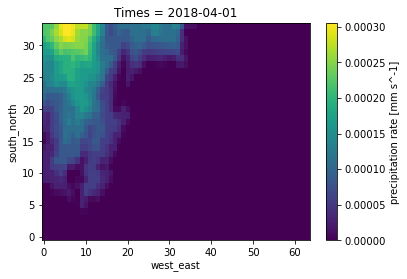

In [151]:
ds.precip_rate[0].plot()

In [9]:
# resample the data to daily timestep
daily_precip_rate = ds.precip_rate.resample(Times='1D').mean()

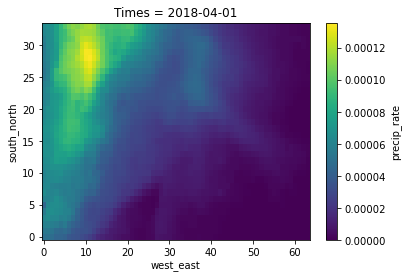

In [14]:
daily_precip_rate.isel(Times=0).plot()

In [15]:
LATEST_OUTPUT = ! ls .. | grep OUTPUT | tail -n 1
LATEST_OUTPUT = LATEST_OUTPUT[0]

output_dir = f'../{LATEST_OUTPUT}'
domain_dir = '../DOMAIN'

print(f'Using output folder = {LATEST_OUTPUT}') 

simulation = wrfhydro_utils.Simulation('test',
                                       domain_dir,
                                       output_dir)

Using output folder = OUTPUT.20211118_17_01


In [16]:
m = simulation.plot_domain('06730200')

Loading cached CHRTOUT (consolidated)

Watershed outlet station ID: 06730200
Reaches are symbolized based on the total flow within the time range:
  Start Date: 1900-01-01
  End Date: 2030-01-01



In [21]:
timestep=2

In [22]:
import folium
import matplotlib

data = daily_precip_rate.isel(Times=int(timestep)).values

# normalize the data so it renders nicely
normed_data = (data[0] - np.nanmin(data[0])) / (np.nanmax(data[0]) - np.nanmin(data[0]))

cm = matplotlib.cm.get_cmap('BuPu')
colored_data = cm(normed_data)

folium.raster_layers.ImageOverlay(colored_data,
                                  [[lat.min(), lon.min()], [lat.max(), lon.max()]],
                                  mercator_project=True,
                                  opacity=0.5).add_to(m)
m

## Animate Daily Aggregate Rainrate

In [176]:
import animatplot as amp
import matplotlib.pyplot as plt


In [177]:
st = '2018-04-01'
et = '2018-04-05'
#ds.sel(time=slice('2000-06-01', '2000-06-10'))

In [178]:
data = ds.sel(Times=slice(st, et))

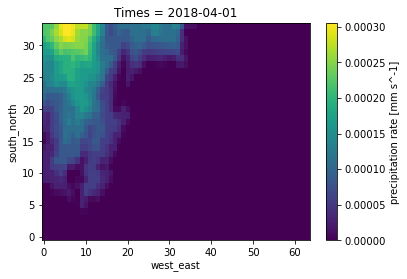

In [180]:
data.precip_rate.isel(Times=0).plot()

In [196]:
data

<xarray.Dataset>
Dimensions:      (Times: 120, south_north: 34, west_east: 64, Time: 1)
Coordinates:
  * Times        (Times) datetime64[ns] 2018-04-01 ... 2018-04-05T23:00:00
Dimensions without coordinates: south_north, west_east, Time
Data variables:
    lat          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
    lon          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
    valid_time   (Times, Time) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    precip_rate  (Times, Time, south_north, west_east) float64 dask.array<chunksize=(1, 1, 34, 64), meta=np.ndarray>

In [204]:
data.precip_rate.isel(Times=0).plot.imshow('west_east', 'south_north')

ValueError: A 3-dimensional array was passed to imshow(), but there is no dimension that could be color.  At least one dimension must be of size 3 (RGB) or 4 (RGBA), and not given as x or y.

In [229]:
data

<xarray.Dataset>
Dimensions:      (Times: 120, south_north: 34, west_east: 64, Time: 1)
Coordinates:
  * Times        (Times) datetime64[ns] 2018-04-01 ... 2018-04-05T23:00:00
Dimensions without coordinates: south_north, west_east, Time
Data variables:
    lat          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
    lon          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
    valid_time   (Times, Time) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    precip_rate  (Times, Time, south_north, west_east) float64 dask.array<chunksize=(1, 1, 34, 64), meta=np.ndarray>

In [262]:
dat = ds.squeeze(dim='Time')

In [264]:
dat = dat.precip_rate.resample(Times='1D').mean().to_dataset()

In [268]:
dat = dat.rename({'south_north': 'y', 'west_east':'x'})

In [269]:
dat

<xarray.Dataset>
Dimensions:      (Times: 183, y: 34, x: 64)
Coordinates:
  * Times        (Times) datetime64[ns] 2018-04-01 2018-04-02 ... 2018-09-30
Dimensions without coordinates: y, x
Data variables:
    precip_rate  (Times, y, x) float64 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>

In [272]:
#block = data.precip_rate.plot.imshow('west_east', 'south_north', animate_over='Times')
block = dat["precip_rate"].plot.imshow(animate_over='time')

ValueError: A 3-dimensional array was passed to imshow(), but there is no dimension that could be color.  At least one dimension must be of size 3 (RGB) or 4 (RGBA), and not given as x or y.

In [208]:
anim = Animation([block])

AttributeError: '_Dataset_PlotMethods' object has no attribute 'imshow'

In [ ]:
anim.save_gif("fluid_density.gif") 
plt.show()

In [184]:
data2

<xarray.Dataset>
Dimensions:      (Times: 120, south_north: 34, west_east: 64, Time: 1)
Coordinates:
    lat          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
    lon          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
  * Times        (Times) datetime64[ns] 2018-04-01 ... 2018-04-05T23:00:00
Dimensions without coordinates: south_north, west_east, Time
Data variables:
    valid_time   (Times, Time) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    precip_rate  (Times, Time, south_north, west_east) float64 dask.array<chunksize=(1, 1, 34, 64), meta=np.ndarray>

In [182]:
data2 = data.set_coords(['lat', 'lon'])


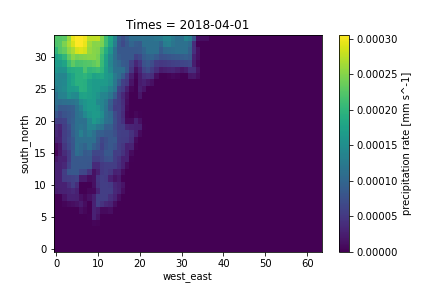

In [170]:
time = pnw.Player(name='time', start=0, end=100, loop_policy='loop', interval=100)
data2.precip_rate.interactive(loc='bottom').isel(Times=time).plot()
#data2.precip_rate.interactive.sel(Times=pnw.DiscreteSlider).plot()

In [109]:
data2

<xarray.Dataset>
Dimensions:      (Times: 24, south_north: 34, west_east: 64, Time: 1)
Coordinates:
    lat          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
    lon          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
  * Times        (Times) datetime64[ns] 2018-04-01 ... 2018-04-01T23:00:00
Dimensions without coordinates: south_north, west_east, Time
Data variables:
    valid_time   (Times, Time) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    precip_rate  (Times, Time, south_north, west_east) float64 dask.array<chunksize=(1, 1, 34, 64), meta=np.ndarray>

In [104]:
data2.precip_rate.isel(0).hvplot(
    groupby="Times",  # adds a widget for time
    clim=(250, 295),  # sets colormap limits
)

ValueError: the first argument to .isel must be a dictionary

In [34]:
ds

<xarray.Dataset>
Dimensions:      (Times: 4377, south_north: 34, west_east: 64, Time: 1)
Coordinates:
  * Times        (Times) datetime64[ns] 2018-04-01 ... 2018-09-30T23:00:00
Dimensions without coordinates: south_north, west_east, Time
Data variables:
    lat          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
    lon          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
    valid_time   (Times, Time) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    precip_rate  (Times, Time, south_north, west_east) float64 dask.array<chunksize=(1, 1, 34, 64), meta=np.ndarray>

In [41]:
r = ds.precip_rate.isel(Times=slice(0,50)).resample(Times='1D')

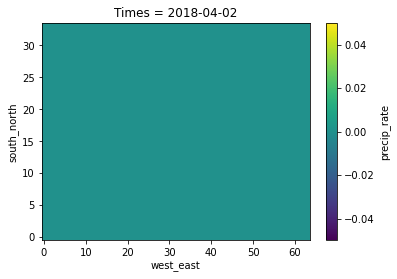

In [44]:
r.mean().isel(Times=1).plot()

In [52]:
ds.precip_rate.isel(Times=0).hvplot(
groupby='Times',
    clim=(250, 295),  # sets colormap limits
    widget_type="scrubber",
    widget_location="bottom",)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=0, width=550)
        [2] HSpacer()

In [171]:
ds_test = xr.tutorial.load_dataset('air_temperature')

In [172]:
ds_test

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...


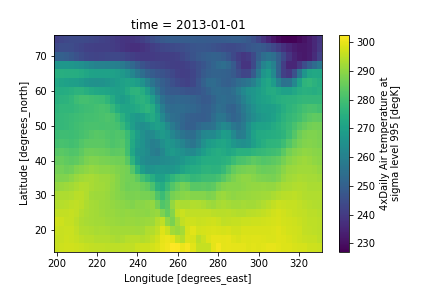

In [174]:
ds_test.air.interactive.sel(time=pnw.DiscreteSlider).plot()

In [74]:
daily_precip_rate

,Array,Chunk
Bytes,3.04 MiB,17.00 kiB
Shape,"(183, 1, 34, 64)","(1, 1, 34, 64)"
Count,28090 Tasks,183 Chunks
Type,float64,numpy.ndarray


In [73]:
data

<xarray.DataArray 'precip_rate' (Times: 10, Time: 1, south_north: 34, west_east: 64)>
dask.array<getitem, shape=(10, 1, 34, 64), dtype=float64, chunksize=(1, 1, 34, 64), chunktype=numpy.ndarray>
Coordinates:
  * Times    (Times) datetime64[ns] 2018-04-01 2018-04-02 ... 2018-04-10
Dimensions without coordinates: Time, south_north, west_east


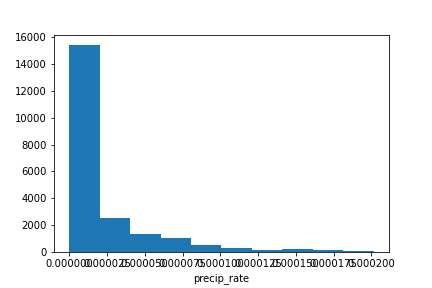

In [72]:
data.interactive(Times=pnw.DiscreteSlider).plot()

In [71]:
data

<xarray.DataArray 'precip_rate' (Times: 10, Time: 1, south_north: 34, west_east: 64)>
dask.array<getitem, shape=(10, 1, 34, 64), dtype=float64, chunksize=(1, 1, 34, 64), chunktype=numpy.ndarray>
Coordinates:
  * Times    (Times) datetime64[ns] 2018-04-01 2018-04-02 ... 2018-04-10
Dimensions without coordinates: Time, south_north, west_east